In [1]:
import pandas as pd
import numpy as np
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

from pyts.transformation import BOSS
from pyts.datasets import load_gunpoint

from catboost import CatBoostClassifier

In [4]:
# # Toy dataset to understand the shape needed
# X_train, _, y_train, _ = load_gunpoint(return_X_y=True)
# X_train.shape
# plt.plot(X_train[0,:]);
# plt.plot(X_train[1,:]);
# plt.plot(X_train[23,:]);
# X_train.shape

In [2]:
raw_data_prep_dir = '../raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0/preprocessed/'

In [3]:
file_list = pd.read_csv(raw_data_prep_dir  + "file_list.csv")
file_list

,resource_type,id,study_id,condition,disease_comment,age_at_diagnosis,age,height,weight,gender,handedness,appearance_in_kinship,appearance_in_first_grade_kinship,effect_of_alcohol_on_tremor,label
0,patient,1,PADS,Healthy,-,56,56,173,78,male,right,True,True,Unknown,0
1,patient,2,PADS,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...,69,81,193,104,male,right,False,NaN,No effect,2
2,patient,3,PADS,Healthy,-,45,45,170,78,female,right,False,NaN,Unknown,0
3,patient,4,PADS,Parkinson's,IPS akinetic-rigid type,63,67,161,90,female,right,False,NaN,No effect,1
4,patient,5,PADS,Parkinson's,IPS tremordominant type,65,75,172,86,male,left,False,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,patient,465,PADS,Parkinson's,IPS mixed type,62,65,175,80,male,right,True,False,No effect,1
465,patient,466,PADS,Healthy,-,84,84,172,74,female,right,True,True,No effect,0
466,patient,467,PADS,Parkinson's,"Essential Tremor, starting IPS tremordominant ...",55,57,190,100,male,right,False,NaN,Improvement,1
467,patient,468,PADS,Parkinson's,IPS mixed type,73,76,198,118,male,right,False,NaN,No effect,1


In [4]:
time_data = []
y = []
X_to_split = []
for idx, subject_idx in enumerate(file_list['id']):
    file_name = raw_data_prep_dir + f'movement/{subject_idx:03d}_ml.bin'
    time_idx_data = np.fromfile(file_name, dtype=np.float32).reshape((-1, 976))
    time_data.append(time_idx_data)
    y_idx = file_list[file_list['id']==subject_idx].label.values
    X_id = idx
    y.append(y_idx)
    X_to_split.append(X_id)

X_to_split = np.array(X_to_split)
y = np.array(y).flatten()
time_data = np.array(time_data)
print(time_data.shape)
time_data.shape[0]
range(time_data.shape[0])

(469, 132, 976)


range(0, 469)

In [6]:
#train test split
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_to_split, y, test_size=0.20, random_state=23, stratify = y)
X_train = time_data[X_train_idx]
X_test = time_data[X_test_idx]
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))
X_train.shape

375 94
375 94


(375, 132, 976)

In [7]:
def channel_wise_boss(time_data, strategy = 'quantile', word_size = 2, window_size = 40, window_step = 2, n_bins = 3):
    boss = BOSS(strategy = strategy,
                word_size = word_size,
                window_size = window_size,
                window_step = window_step,
                n_bins = n_bins)
    boss_output = []
    for c_idx in range(time_data.shape[1]):
        c_data = time_data[:,c_idx,:]
        c_feat = boss.fit(c_data)
        print(c_feat)
        boss_output.append(c_feat)
    return boss_output

In [83]:
boss_output = channel_wise_boss(X_train, word_size = 2, window_size = 30, window_step = 2, n_bins = 4)

BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30,

In [91]:
print(len(boss_output))
boss_output[2]

(X_train[1, 1, :]).reshape(1,-1).shape
len(X_train)

132


375

In [85]:
def boss_transform_data(boss_output,X):
    X_boss = []
    for s_idx in range(X.shape[0]):
        for c_idx in range(X.shape[1]):
            channel_boss= boss_output[c_idx]
            boss_features = channel_boss.transform(X[s_idx,c_idx,:].reshape(1,-1))
            X_boss.append(boss_features.toarray())
    print(len(boss_features.toarray()))
    n_feat = len(boss_features.toarray()[0])
    X_boss_reshape = np.array(X_boss).reshape(len(X),X.shape[1]*n_feat)
    return X_boss_reshape

In [86]:
X_boss_train = boss_transform_data(boss_output, X_train)
X_boss_train

1


array([[ 0,  0,  0, ..., 17, 14, 16],
       [ 0,  1,  1, ..., 16, 10,  3],
       [ 0,  0,  0, ..., 18, 21, 20],
       ...,
       [ 0,  0,  0, ..., 18, 18, 14],
       [ 0,  0,  0, ..., 23,  5,  0],
       [ 0,  0,  0, ..., 14,  8,  0]], shape=(375, 2112))

In [87]:
test = boss_output[1].transform(X_train[1,1,:].reshape(1,-1))
len(test.toarray()[0])

16

In [88]:
pd.DataFrame(X_boss_train)

,0,1,2,3,4,5,6,7,8,9,...,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111
0,0,0,0,0,0,44,53,0,0,12,...,14,16,15,17,20,18,12,17,14,16
1,0,1,1,0,0,35,32,1,1,17,...,17,15,7,25,25,17,5,16,10,3
2,0,0,0,0,2,30,26,4,1,26,...,5,14,11,8,7,19,18,18,21,20
3,0,0,0,0,0,49,48,0,0,10,...,27,23,13,15,14,20,5,4,7,6
4,0,0,0,0,0,38,42,0,0,13,...,21,4,3,21,18,3,2,8,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,0,0,0,0,48,57,0,0,8,...,24,8,7,25,21,3,6,14,10,4
371,0,0,0,0,0,40,39,0,0,11,...,10,11,14,12,8,5,20,22,14,3
372,0,0,0,0,0,41,42,0,0,11,...,7,13,14,10,10,9,13,18,18,14
373,0,0,0,0,0,30,39,0,0,16,...,21,17,7,22,26,13,14,23,5,0


In [ ]:
#s_scaler = StandardScaler()
#s_scaler.fit(X_boss_train)
#X_boss_train_scaled = s_scaler.transform(X_boss_train)

In [92]:
xgb = XGBClassifier()

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

xgb.fit(X_boss_train, y_train, sample_weight=sample_weights)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [93]:
X_boss_test = boss_transform_data(boss_output, X_test)
#X_boss_test_scaled = s_scaler.transform(X_boss_test)

1


In [94]:
y_pred_xgb  = xgb.predict(X_boss_test)

In [95]:
xgb_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)
f'xgb_accuracy: {xgb_accuracy}'

'xgb_accuracy: 0.5819499341238471'

In [96]:
cat_model = CatBoostClassifier(iterations = 2000, learning_rate = 0.05,depth = 7)

In [ ]:
cat_model.fit(X_boss_train,y_train,
              eval_set = (X_boss_test, y_test),
              use_best_model = True,
              #sample_weight = sample_weights
              # )

0:	learn: 1.0862984	test: 1.0989373	best: 1.0989373 (0)	total: 45.1ms	remaining: 1m 30s
1:	learn: 1.0734223	test: 1.0929458	best: 1.0929458 (1)	total: 72.5ms	remaining: 1m 12s
2:	learn: 1.0628235	test: 1.0898395	best: 1.0898395 (2)	total: 101ms	remaining: 1m 7s
3:	learn: 1.0513913	test: 1.0876795	best: 1.0876795 (3)	total: 128ms	remaining: 1m 3s
4:	learn: 1.0408940	test: 1.0866575	best: 1.0866575 (4)	total: 155ms	remaining: 1m 1s
5:	learn: 1.0321613	test: 1.0843088	best: 1.0843088 (5)	total: 184ms	remaining: 1m 1s
6:	learn: 1.0217211	test: 1.0769671	best: 1.0769671 (6)	total: 210ms	remaining: 59.7s
7:	learn: 1.0096630	test: 1.0756106	best: 1.0756106 (7)	total: 236ms	remaining: 58.7s
8:	learn: 0.9978982	test: 1.0725462	best: 1.0725462 (8)	total: 263ms	remaining: 58.2s
9:	learn: 0.9886037	test: 1.0724472	best: 1.0724472 (9)	total: 291ms	remaining: 57.9s
10:	learn: 0.9781450	test: 1.0684822	best: 1.0684822 (10)	total: 317ms	remaining: 57.3s
11:	learn: 0.9708186	test: 1.0682310	best: 1.068

In [101]:
y_pred_cat = cat_model.predict(X_boss_test)
print(y_pred_cat)

[[1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [1]
 [2]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [0]
 [2]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [2]
 [2]
 [1]
 [0]]


In [102]:
cat_accuracy = balanced_accuracy_score(y_test, y_pred_cat)
f'cat_accuracy: {cat_accuracy}'

'cat_accuracy: 0.5590250329380764'

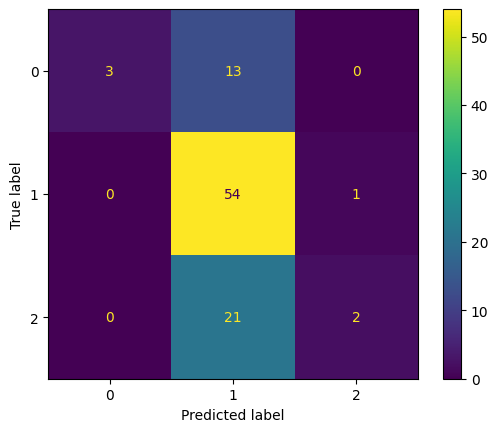

In [94]:
cm_cat = confusion_matrix(y_test,y_pred_cat)
disp_cm_cat  = ConfusionMatrixDisplay(cm_cat)
disp_cm_cat.plot();

In [ ]:
cat_model.select_features(X_boss_train, y_train, features_for_select=list(range(X_boss_train.shape[1])), train_final_model=False, eval_set=(X_boss_test, y_test), num_features_to_select=80)

Step #1 out of 1
0:	learn: 1.0863216	test: 1.0933307	best: 1.0933307 (0)	total: 312ms	remaining: 10m 23s
1:	learn: 1.0694643	test: 1.0805878	best: 1.0805878 (1)	total: 434ms	remaining: 7m 13s
2:	learn: 1.0525361	test: 1.0671865	best: 1.0671865 (2)	total: 549ms	remaining: 6m 5s
3:	learn: 1.0393779	test: 1.0577503	best: 1.0577503 (3)	total: 668ms	remaining: 5m 33s
4:	learn: 1.0263988	test: 1.0477870	best: 1.0477870 (4)	total: 775ms	remaining: 5m 9s
5:	learn: 1.0145278	test: 1.0396755	best: 1.0396755 (5)	total: 872ms	remaining: 4m 49s
6:	learn: 0.9981320	test: 1.0320606	best: 1.0320606 (6)	total: 972ms	remaining: 4m 36s
7:	learn: 0.9862107	test: 1.0280634	best: 1.0280634 (7)	total: 1.09s	remaining: 4m 30s
8:	learn: 0.9723280	test: 1.0189842	best: 1.0189842 (8)	total: 1.21s	remaining: 4m 27s
9:	learn: 0.9604787	test: 1.0121657	best: 1.0121657 (9)	total: 1.31s	remaining: 4m 21s
10:	learn: 0.9508290	test: 1.0062612	best: 1.0062612 (10)	total: 1.41s	remaining: 4m 15s
11:	learn: 0.9399654	test

KeyboardInterrupt: 

Exception ignored in: '_catboost._WriteLog'
Traceback (most recent call last):
  File "/Users/anna/.pyenv/versions/3.10.6/envs/spark/lib/python3.10/site-packages/ipykernel/iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


Feature #7959 eliminated


In [180]:
pca = PCA()

In [181]:
pca = PCA()
X_pca_train = pca.fit_transform(X= X_boss_train)
X_pca_test = pca.transform(X=X_boss_test)

In [182]:
np.array(X_pca_train)
X_pca_train.shape
X_pca_test.shape

(94, 375)

In [195]:
cat_model_pca = CatBoostClassifier(iterations = 2000, learning_rate = 0.05,depth = 7)

In [196]:
cat_model_pca.fit(X_pca_train, y_train, eval_set = (X_pca_test, y_test), use_best_model = True, sample_weight=sample_weights)

0:	learn: 1.0850506	test: 1.0977299	best: 1.0977299 (0)	total: 75.4ms	remaining: 2m 30s
1:	learn: 1.0701908	test: 1.0937759	best: 1.0937759 (1)	total: 119ms	remaining: 1m 58s
2:	learn: 1.0563116	test: 1.0925775	best: 1.0925775 (2)	total: 151ms	remaining: 1m 40s
3:	learn: 1.0451089	test: 1.0909100	best: 1.0909100 (3)	total: 184ms	remaining: 1m 31s
4:	learn: 1.0353070	test: 1.0888119	best: 1.0888119 (4)	total: 217ms	remaining: 1m 26s
5:	learn: 1.0244710	test: 1.0870982	best: 1.0870982 (5)	total: 250ms	remaining: 1m 22s
6:	learn: 1.0137772	test: 1.0875619	best: 1.0870982 (5)	total: 282ms	remaining: 1m 20s
7:	learn: 1.0014034	test: 1.0876612	best: 1.0870982 (5)	total: 317ms	remaining: 1m 18s
8:	learn: 0.9905742	test: 1.0861035	best: 1.0861035 (8)	total: 352ms	remaining: 1m 17s
9:	learn: 0.9815203	test: 1.0817075	best: 1.0817075 (9)	total: 389ms	remaining: 1m 17s
10:	learn: 0.9741976	test: 1.0803315	best: 1.0803315 (10)	total: 424ms	remaining: 1m 16s
11:	learn: 0.9628168	test: 1.0785677	bes

In [197]:
xgb = XGBClassifier()

In [199]:
xgb.fit(X_pca_train, y_train, sample_weight=sample_weights)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [200]:
y_pred_pca_xgb = xgb.predict(X_pca_test)
y_pred_pca_xgb

array([1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       0, 1, 1, 1, 2, 0])

In [ ]:
y_pred_pca_cat = cat_model.predict(X_pca_test)
y_pred_pca_cat

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [2],
       [0],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [202]:
balanced_accuracy_score(y_test, y_pred_pca_xgb)

0.4327733860342556

In [203]:
balanced_accuracy_score(y_test, y_pred_pca_cat)

0.44224308300395254

In [204]:
sv_model = SVC(kernel = 'linear', class_weight = 'balanced', C = 1)

In [205]:
sv_model.fit(X_pca_train, y_train)

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [206]:
y_pred_pca_sv = sv_model.predict(X_pca_test)
balanced_accuracy_score(y_test, y_pred_sv)

0.5021080368906456

In [207]:
sv_model.fit(X_boss_train, y_train)

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [208]:
y_pred_sv = sv_model.predict(X_boss_test)
balanced_accuracy_score(y_test, y_pred_sv)

0.5021080368906456